In [1]:
import os
from glob import glob

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import PowerTransformer, PolynomialFeatures, OneHotEncoder as hot
from sklearn.feature_selection import SelectKBest as slk

from sklearn.linear_model import LinearRegression as lr
from sklearn.model_selection import cross_val_score as cv_score, train_test_split as tts
from sklearn.metrics import r2_score as r2, mean_squared_error as mse
from sklearn.neighbors import KNeighborsRegressor as knnr

### Links to documentation
- sklearn prepocessing: https://scikit-learn.org/stable/modules/preprocessing.html
- preprocessing API: https://scikit-learn.org/stable/modules/classes.html#module-sklearn.preprocessing
- PowerTransformer function: https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PowerTransformer.html#sklearn.preprocessing.PowerTransformer
- GridSearchCV documentation: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html#sklearn.model_selection.GridSearchCV
- train_test_split function: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

#### Further reading
- When to standardize data: http://www.faqs.org/faqs/ai-faq/neural-nets/part2/section-16.html
- Hyper paramater optimization library comparison: https://towardsdatascience.com/hyperparameter-optimization-in-python-part-1-scikit-optimize-754e485d24fe
- Python function decorators: https://www.thecodeship.com/patterns/guide-to-python-function-decorators/

#### Other resources
- Comp AI mailing: https://groups.google.com/forum/#!forum/comp.ai.neural-nets
- https://www.ritchieng.com/machinelearning-one-hot-encoding/

## Initial variables
Continuous variables
- lotfrontage
- lotarea
- yearremodadd
- yearbuilt
- masvnrarea
- bsmtfinsf1
- totalbsmtsf
- 1stflrsf
- 2ndflrsf
- grlivarea
- garagearea
- wooddecksf

Categorical variables
- mszoning
- centralair
- neighborhood
- saletype
- condition1
- condition2
- housestyle
- yrsold (could also be continuous)
- mosold (could also be continuous)

## Experimental Choices
Dealing with the 258 missing values in lot frontage variable
- Drop values
- Set values equal to zero
- Set values equal to the mean
- Create a dummy variable (and set values to zero)
- Estimate from lot area

## Non-experimental cleaning
- Drop records with null masvnrarea
- Combine Condition1 and Condition2

In [30]:
path = 'H:/Documents/Training/Thinkful/housing_prices_kaggle'
file = 'train.csv'

os.chdir(path)

d = pd.read_csv(file)
d.columns = d.columns.str.lower()

In [31]:
# Creating metadata dataframe that will be used in data discovery and analysis
md = pd.DataFrame()
md['dtype'] = d.dtypes
md['nulls'] = d.apply(lambda x: sum(x.isna()))
md['levels'] = d.apply(lambda x: len(x.drop_duplicates()))

md.loc[md.dtype=='object', 'vtype'] = 'categorical'
md.loc[(md.dtype != 'object') & (md.levels>30), 'vtype'] = 'interval'
md.loc['saleprice', 'vtype'] = 'target'
md.loc[['yrsold', 'mosold'], 'vtype'] = 'categorical'

In [32]:
cat = ['mszoning', 'centralair', 'neighborhood', 'saletype', 
       'condition1', 'condition2', 'housestyle', 'yrsold',
      'mosold']

cnt_groups = {'blt_area': ['grlivarea', '2ndflrsf', '1stflsf', 'garagearea', 'totalbsmtsf'],
             'blt_yr': ['yearbuilt', 'yearremodadd', 'garageyrblt']}

cnt = ['lotfrontage', 'lotarea', 'yearremodadd', 'yearbuilt', 
            'masvnrarea', 'bsmtfinsf1', 'totalbsmtsf', '1stflrsf',
           '2ndflrsf', 'grlivarea', 'garagearea', 'wooddecksf']

target = ['saleprice']

# Model Group 1 - In which I don't try very hard
1. Drop all null values
2. Include all variables
3. All categorical variables are one hot encoded
4. No scaling or other transformations of continuous variables
5. Vary number of neighbors
6. No interaction variables in linear model

## Data preparation

In [33]:
# Select variables of interest
feat = d[cat+cnt+target].dropna()
X = feat[cat+cnt]
y = feat[target]

X_train, X_test, y_train, y_test = tts(X, y, test_size=0.33)

#### Consolidating duplicate "condition" columns

In [34]:
def melt_feature(df_, cols=None, idvars=None, vr_name='variable_name', val_name='value_name'):
    try:
        # Determines columns to melt if the ID variables are specified
        if cols==None and idvars != None:
            cols = [x for x in df_.columns if x not in idvars]

        # Makes my life easier for this particular use case
        elif cols==None:
            cols = ['condition1', 'condition2']

        # Sets the ID variables automatically if the columns to melt are specified
        if idvars==None:
            idvars = [x for x in df_.columns if x not in cols]

        # Stack analogous columns
        df = df_.copy().melt(id_vars = idvars, var_name=vr_name, value_name=val_name)

        # Creates indicator columns
        df['flag'] = 1

        # Drops the names of the original columns--which aren't needed--
        # and gets rid of duplicates.
        df = df.drop(vr_name, axis=1).groupby(idvars+[val_name]).max()

        # Converts the dataframe back to wide form
        df = df.unstack(fill_value=0)['flag']
        df.columns.name=None
        df = df.reset_index()
        return(df)
    
    except Exception as e:
        print(e)
        return(False)


def reconcile(test, train):
    try:
        add = train.columns.difference(test.columns)
        drp = test.columns.difference(train.columns)

        df = test.copy()
        if len(add) > 0:
            add_df = pd.DataFrame(np.zeros(shape=(len(test.index), len(add))), columns=add.values)
            df = pd.concat([df, add_df], axis=1)
            print('Additional fields in train dataset: {0}'.format(len(add)))
            print(add)
        else:
            print('Training dataset has no additional columns compared to test dataset.')

        if len(drp) > 0:
            df = df.drop(drp, axis=1)
            print('\nAdditional fields in test dataset: {0}'.format(len(drp)))
            print(drp)
        else:
            print('\nTesting dataset has no additional columns compared to training dataset.')

        return(df)
    
    except Exception as e:
        print(e)
        return(False)

In [35]:
X_train1 = melt_feature(X_train)
X_test_1 = melt_feature(X_test)

X_test1 = reconcile(X_test_1, X_train1)

Additional fields in train dataset: 1
Index(['RRNe'], dtype='object')

Testing dataset has no additional columns compared to training dataset.


#### One Hot Encoding

In [37]:
from functools import reduce

cat = list(filter(lambda x: x not in ('condition1', 'condition2'), cat))

enc = hot(drop='first')
enc.fit(X_train1[cat])

# Storing reference levels and columns names
ref_cat = pd.Series(enc.categories_, index=cat).apply(lambda x: x[0])
new_cat = pd.Series(enc.categories_, index=cat).apply(lambda x: x[1:len(x)])
new_cat_cols = list(reduce(lambda x,y: np.append(x,y), new_cat))

# Transforming test and train datasets
X_train_cat = pd.DataFrame(enc.transform(X_train1[cat]).toarray(), columns=new_cat_cols)
X_train2 = pd.concat([X_train_cat, X_train1[[x for x in X_train1 if x not in cat]]], axis=1)

X_test1.iloc[:, 3].value_counts()

X_test_cat = pd.DataFrame(enc.transform(X_test1[cat]).toarray(), columns=new_cat_cols)
X_test2 = pd.concat([X_test_cat, X_test1[[x for x in X_test1 if x not in cat]]], axis=1)

## Linear Regression Model 1

In [38]:
regr = lr().fit(X_train2, y_train)
y_tr = regr.predict(X_train2)
y_ts = regr.predict(X_test2)

# Train metrics
r2_train = r2(y_tr.ravel(), y_train)
mse_train = mse(y_tr.ravel(), y_train)
print('Training R2:')
print(r2_train)
print('\nTraining mean squared error:')
print(mse_train)

# Test metrics
r2_test = r2(y_ts.ravel(), y_test)
mse_test= mse(y_ts.ravel(), y_test)
print('\nTest R2:')
print(r2_test)
print('\nTest mean squared error:')
print(mse_test)

Training R2:
-11.210996626962583

Training mean squared error:
5568146694.66502

Test R2:
-13.384710367576458

Test mean squared error:
9629697874.334034


So that's...pretty terrible. Let's look at the residual plots.

Residual mean: 2978.125
Residual median: -18131.51


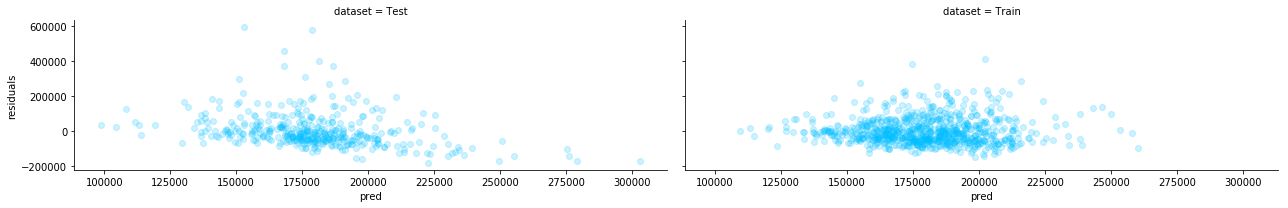

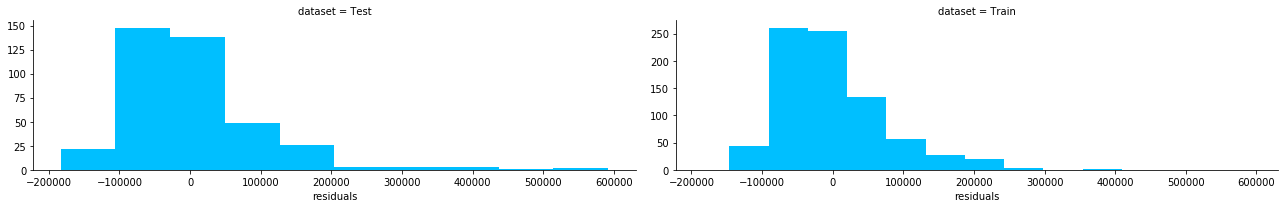

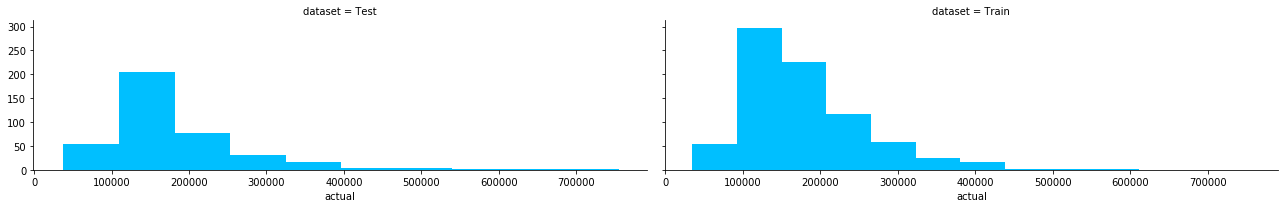

In [39]:
# Test values
tst = pd.DataFrame()
tst['actual'] = y_test.saleprice
tst['residuals'] = y_test.saleprice - y_ts.ravel()
tst['pred'] = y_ts.ravel()
tst['dataset'] = 'Test'

mn_ts = tst.residuals.mean()
mdn_ts = tst.residuals.median()

# Train values
trn = pd.DataFrame()
trn['actual'] = y_train.saleprice
trn['residuals'] = y_train.saleprice - y_tr.ravel()
trn['pred'] = y_tr.ravel()
trn['dataset'] = 'Train'

mn_tr = trn.residuals.mean()
mdn_tr = trn.residuals.median()

results = pd.concat([tst, trn])

# print(regr.coef_)
print('Residual mean: {0}'.format(round(mn_ts, ndigits=3)))
print('Residual median: {0}'.format(round(mdn_ts, ndigits=3)))

g = sns.FacetGrid(results, col='dataset', aspect=3)
g.map(plt.scatter, 'pred', 'residuals', alpha=0.2, color='deepskyblue')
plt.show()

g = sns.FacetGrid(results, col='dataset', aspect=3, sharey=False)
g.map(plt.hist, 'residuals', color='deepskyblue')
plt.show()

results.actual.median()
g = sns.FacetGrid(results, col='dataset', aspect=3)
g.map(plt.hist, 'actual', color='deepskyblue')
plt.show()

The residual distribution is right tailed, the residual median is very negative, and the residuals appear to become more negative as the predictions increase. It might indicate colinear effects or the presence of a few outliers with higher sales prices in the training set.

## KNN Model 1

In [40]:
kreg = knnr(n_neighbors=5)  
kreg.fit(X_train2, y_train.saleprice)
y_tr = kreg.predict(X_train2)
y_ts = kreg.predict(X_test2)

print('Model R2: {0}'.format(round(r2(y_tr, y_train.saleprice), ndigits=3)))
print('Model mean squared error: {0}'.format(round(mse(y_tr, y_train.saleprice), ndigits=3)))
print('\nTest R2: {0}'.format(round(r2(y_ts, y_test.saleprice), ndigits=3)))
print('Test mean squared error: {0}'.format(round(mse(y_ts, y_test.saleprice), ndigits=3)))

Model R2: -3.722
Model mean squared error: 4970580407.969

Test R2: -8.519
Test mean squared error: 10093281933.375


And KNN is even worse! Then again, I didn't do any scaling and I added a ton of binary variables. So far it looks like these models are just bad, not necessarily overfitting. So let's start over with only the continuous variables and see how that works.

# Model Group 2: Continuous Variables Only
I will not attempt to do any scaling. Since it's hard to determine what's happening with so many variables, I'm starting with continuous variables only and seeing if I can improve performance.

In [41]:
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf

feat.columns = feat.columns.str.replace('1st', 'first_').str.replace('2nd', 'sec_')
cnt_new = pd.Series(cnt).str.replace('1st', 'first_').str.replace('2nd', 'sec_')
X = feat[pd.Series(cnt).str.replace('1st', 'first_').str.replace('2nd', 'sec_')]
y = feat[target]

## Linear Regression Model 2

In [42]:
# Define the data structures to hold the test results
pred_cols = ['exp_no', 'actual', 'pred', 'dataset', 'model_type']
run_cols = ['exp_no', 'r2_train', 'r2_test', 'mse_train', 'mse_test', 'ols_summary']
runs = pd.DataFrame(columns=run_cols)
predictions = pd.DataFrame(columns=pred_cols)


# Running the experiment 10 times, though not a true cross-validation
for i in range(100):
    rrow = dict()
    test = pd.DataFrame()
    train = pd.DataFrame()
    
    X_train, X_test, y_train, y_test = tts(X, y, test_size=0.33)
    rrow['exp_no'] = i
    train['actual'] = y_train.saleprice
    train['exp_no'] = i
    train['dataset'] = 'Train'
    test['actual'] = y_test.saleprice
    test['exp_no'] = i
    test['dataset'] = 'Test'
    
    dtrain = pd.concat([X_train, y_train], axis=1)

    ind = str(reduce(lambda x,y: '{0} + {1}'.format(x,y), X_train.columns))
    mod = smf.ols('saleprice ~ {0}'.format(ind), data=dtrain)
    results = mod.fit()
    summ = results.summary()
    rrow['ols_summary'] = summ

    y_ts = results.get_prediction(X_test).__dict__['predicted_mean']
    test['pred'] = y_ts
    y_tr = results.get_prediction(X_train).__dict__['predicted_mean']
    train['pred'] = y_tr

    rrow['r2_train'] = r2(y_tr.ravel(), y_train)
    rrow['mse_train'] = mse(y_tr.ravel(), y_train)

    rrow['r2_test'] = r2(y_ts.ravel(), y_test)
    rrow['mse_test'] = mse(y_ts.ravel(), y_test)
    
    runs = runs.append(rrow, ignore_index=True)
    exp_records = pd.concat([test, train], axis=0, sort=True)
    exp_records['model_type'] = 'ols'
    predictions = pd.concat([predictions, exp_records], axis=0, sort=True)


# Printing the results
nd = 4
print('Number of runs: {0}\n'.format(len(runs.r2_train)))
print('Mean of train R2: {0}'.format(round(runs.r2_train.mean(), ndigits=nd)))
print('STD of train R2: {0}'.format(round(runs.r2_train.std(), ndigits=nd)))

print('')
print('Mean of test R2: {0}'.format(round(runs.r2_test.mean(), ndigits=nd)))
print('STD of test R2: {0}'.format(round(runs.r2_test.std(), ndigits=nd)))

Number of runs: 100

Mean of train R2: 0.6642
STD of train R2: 0.0644

Mean of test R2: 0.6267
STD of test R2: 0.0594


The higher training R2 compared to testing R2 suggests that the model is overfitted, which may be explained by colinearity between several variables, as illustrated in the correlation analysis below.

## KNN Model 2
Hypothesis: I would expect this KNN to underperform compared to the linear regression; I have conducted no scaling, and there is considerable scale difference between variables.

In [43]:
## knn_pred = pd.DataFrame(columns=pred_cols)
knn_runs = pd.DataFrame(columns=[x for x in run_cols if x != 'ols_summary'])
knn_pred = pd.DataFrame(columns=pred_cols)

for i in range(100):
    X_train, X_test, y_train, y_test = tts(X, y, test_size=0.33)
    test = pd.DataFrame()
    test['actual'] = y_test.saleprice
    train = pd.DataFrame()
    train['actual'] = y_train.saleprice
    test['exp_no'] = i
    train['exp_no'] = i
    test['dataset'] = 'Test'
    train['dataset'] = 'Train'
    
    kreg = knnr(n_neighbors=5)  
    kreg.fit(X_train, y_train.saleprice)
    
    y_tr = kreg.predict(X_train)
    y_ts = kreg.predict(X_test)
    train['pred'] = y_tr
    test['pred'] = y_ts
    
    record = pd.concat([train, test], axis=0, sort=True)
    record['model_type'] = 'knn'
    knn_pred = pd.concat([knn_pred, record], axis=0, sort=True)
    
    rrow = {'exp_no': i, 'r2_train': r2(y_tr, y_train.saleprice), 'mse_train': mse(y_tr, y_train.saleprice),
           'r2_test': r2(y_ts, y_test.saleprice), 'mse_test': mse(y_ts, y_test.saleprice)}
    knn_runs = knn_runs.append(rrow, ignore_index=True)

In [44]:
nd=nd
print('Number of trials: {0}\n'.format(len(knn_runs)))
print('Mean model R2: {0}'.format(round(knn_runs.r2_train.mean(), ndigits=nd)))
print('STD model R2: {0}\n'.format(round(knn_runs.r2_train.std(), ndigits=nd)))
print('Mean test R2: {0}'.format(round(knn_runs.r2_test.mean(), ndigits=nd)))
print('STD test R2: {0}'.format(round(knn_runs.r2_test.std(), ndigits=nd)))

Number of trials: 100

Mean model R2: 0.62
STD model R2: 0.0367

Mean test R2: 0.3724
STD test R2: 0.1367


The model R2 for KNN compared to OLS isn't too much smaller, but the test R2 is far, far lower indicating overfitting. That KNN performs worse overall isn't surprising considering I still haven't scaled my variables.

# Model Group 3: Scaled continuous variables
I will not be including categorical variables just yet. I will first conduct an apples to apples comparison between unscaled and scaled continuous variables on both OLS and KNN.

## Data preparation

In [45]:
cnt_ols = pd.Series(cnt).str.replace('1st', 'first_').str.replace('2nd', 'sec_')
feat = d[cnt+['saleprice']]
feat.columns = feat.columns.str.replace('1st', 'first_').str.replace('2nd', 'sec_')
feat = feat.dropna()

X = feat[cnt_ols]
y = feat.saleprice
# feat.head()

## Linear Regression Model 3

In [46]:
from sklearn.preprocessing import StandardScaler

ols_pred = pd.DataFrame(columns=pred_cols)
ols_runs = pd.DataFrame(columns = run_cols)

for i in range(100):
    rrow=dict()
    test = pd.DataFrame()
    train = pd.DataFrame()
    
    X_train, X_test, y_train, y_test = tts(X, y, test_size=0.33)
#     print(y_test)

    test['actual'] = y_test
    test['dataset'] = 'Test'
    test['exp_no'] = i
    
    train['actual'] = y_train
    train['dataset'] = 'Train'
    train['exp_no'] = i
    
    scale = StandardScaler()
    X_sc_train = scale.fit_transform(X_train)
    X_sc_test = scale.transform(X_test)
    
    dtrain = pd.concat([X_train, y_train], axis=1)

    ind = str(reduce(lambda x,y: '{0} + {1}'.format(x,y), X_train.columns))
    mod = smf.ols('saleprice ~ {0}'.format(ind), data=dtrain)
    results = mod.fit()
    
    summ = results.summary()

    y_ts = results.get_prediction(X_test).__dict__['predicted_mean']
    test['pred'] = y_ts
    y_tr = results.get_prediction(X_train).__dict__['predicted_mean']
    train['pred'] = y_tr
    
    exp_records = pd.concat([test, train], axis=0, sort=True)
    exp_records['model_type'] = 'ols'
    ols_pred = pd.concat([ols_pred, exp_records], axis=0, sort=True)
    
    rrow = {'ols_summary': summ,
            'r2_train': r2(y_tr.ravel(), y_train),
            'mse_train': mse(y_tr.ravel(), y_train),
            'r2_test': r2(y_ts.ravel(), y_test),
            'mse_test': mse(y_ts.ravel(), y_test),
            'exp_no': i
           }
    
    ols_runs = ols_runs.append(rrow, ignore_index=True)
    
    
print('Number of trials: {0}\n'.format(len(ols_runs.index)))
print('Mean model R2: {0}'.format(round(ols_runs.r2_train.mean(), ndigits=nd)))
print('STD model R2: {0}'.format(round(ols_runs.r2_train.std(), ndigits=nd)))
print('Mean model MSE: {0}\n'.format(round(ols_runs.mse_train.mean(), ndigits=nd)))
print('Mean test R2: {0}'.format(round(ols_runs.r2_test.mean(), ndigits=nd)))
print('STD test R2: {0}'.format(round(ols_runs.r2_test.std(), ndigits=nd)))
print('Mean test MSE: {0}'.format(round(ols_runs.mse_test.mean(), ndigits=nd)))

Number of trials: 100

Mean model R2: 0.6765
STD model R2: 0.0753
Mean model MSE: 1682979703.0503

Mean test R2: 0.6237
STD test R2: 0.0693
Mean test MSE: 2164101311.2744


Interesting. Just scaling seems to have corrected much of the overfitting. Let's see if that stays consistent for KNN.

## KNN Model 3
We would expect this KNN model to outperform KNN models 1 and 2.

In [47]:
## knn_pred = pd.DataFrame(columns=pred_cols)
knn_runs = pd.DataFrame(columns=[x for x in run_cols if x != 'ols_summary'])
knn_pred = pd.DataFrame(columns=pred_cols)

for i in range(100):
    rrow = dict()
    
    X_train, X_test, y_train, y_test = tts(X, y, test_size=0.33)
    
    scale = StandardScaler()
    X_sc_train = scale.fit_transform(X_train)
    X_sc_test = scale.transform(X_test)
    
    kreg = knnr(n_neighbors=5)  
    kreg.fit(X_sc_train, y_train)
    
    y_tr = kreg.predict(X_sc_train)
    y_ts = kreg.predict(X_sc_test)
    train['pred'] = y_tr
    test['pred'] = y_ts
    
    test = pd.DataFrame({'actual': y_test,
                         'exp_no': i,
                         'dataset': 'Test',
                         'pred': y_ts
                        })
    
    train = pd.DataFrame({'actual': y_train,
                          'exp_no': i,
                          'dataset': 'Train',
                          'pred': y_tr
                         })
    
    record = pd.concat([train, test], axis=0, sort=True)
    record['model_type'] = 'knn'
    knn_pred = pd.concat([knn_pred, record], axis=0, sort=True)
    
    rrow = {'exp_no': i, 'r2_train': r2(y_tr, y_train), 'mse_train': mse(y_tr, y_train),
           'r2_test': r2(y_ts, y_test), 'mse_test': mse(y_ts, y_test)}
    knn_runs = knn_runs.append(rrow, ignore_index=True)

print('Number of trials: {0}\n'.format(len(knn_runs.index)))
print('Mean model R2: {0}'.format(round(knn_runs.r2_train.mean(), ndigits=nd)))
print('STD model R2: {0}'.format(round(knn_runs.r2_train.std(), ndigits=nd)))
print('Mean model MSE: {0}\n'.format(round(knn_runs.mse_train.mean(), ndigits=nd)))
print('Mean test R2: {0}'.format(round(knn_runs.r2_test.mean(), ndigits=nd)))
print('STD test R2: {0}'.format(round(knn_runs.r2_test.std(), ndigits=nd)))
print('Mean test MSE: {0}'.format(round(knn_runs.mse_test.mean(), ndigits=nd)))

Number of trials: 100

Mean model R2: 0.7896
STD model R2: 0.0268
Mean model MSE: 1096141251.4159

Mean test R2: 0.6605
STD test R2: 0.0627
Mean test MSE: 1651016645.7671


The average test R2 indicates that KNN actually outperformed OLS However, the 17.4% difference between the model R2 and the test R2 indicates that this model is overfitting the data compared to OLS model 3.

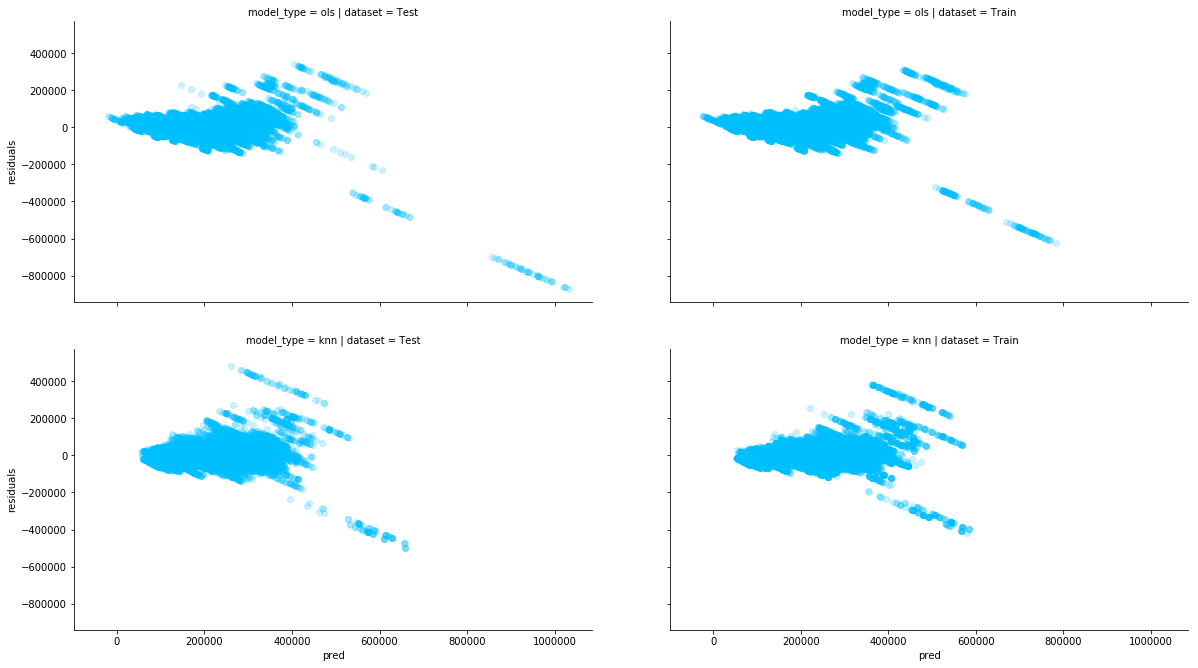

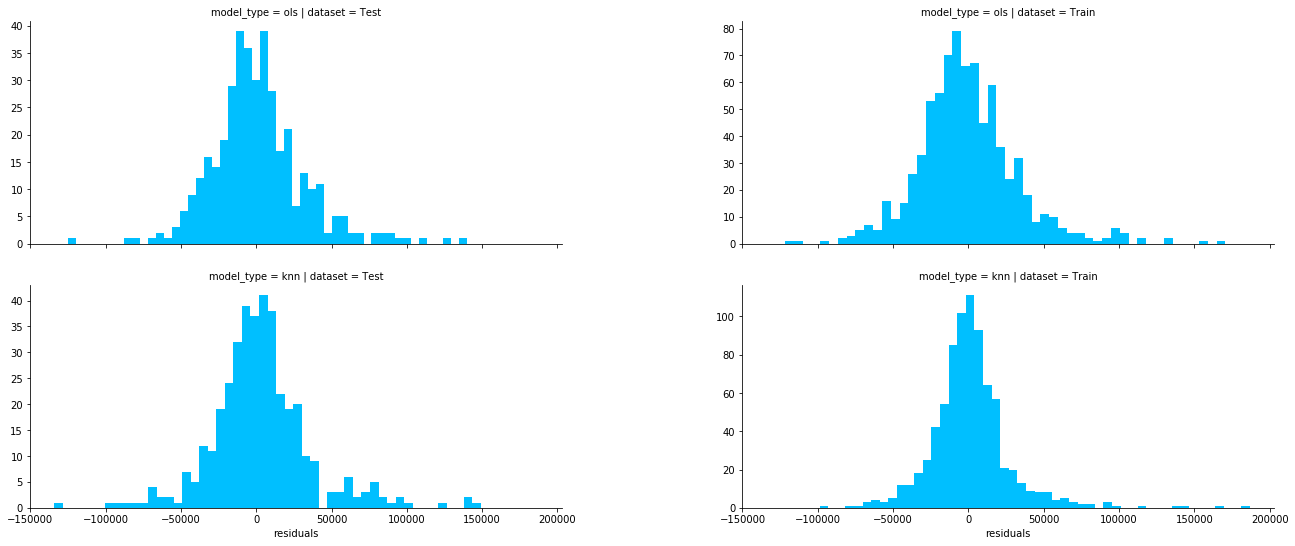

In [49]:
comb = pd.DataFrame()
comb = pd.concat([ols_pred, knn_pred], axis=0, sort=True)
comb.loc[:, 'actual'] = comb.actual.astype(np.float64)
comb.loc[:, 'pred'] = comb.pred.astype(np.float64)
comb['residuals'] = comb.actual - comb.pred
comb.loc[:, 'exp_no'] = comb.exp_no.astype(np.float64)

g = sns.FacetGrid(comb.loc[:, ['dataset', 'model_type', 'pred', 'residuals']],
                  col='dataset', row='model_type')
g.map(plt.scatter, 'pred', 'residuals', color='deepskyblue', alpha=0.2)
f = plt.gcf()
f.set_size_inches(20, 10)
plt.show()

g = sns.FacetGrid(comb.loc[(comb.exp_no==1) & (comb.residuals.abs() < 200000) , ['dataset', 'model_type', 'pred', 'residuals']],
                 col='dataset', row='model_type', sharey=False)
g.map(plt.hist, 'residuals', color='deepskyblue', bins=50)
f = plt.gcf()
f.set_size_inches(20, 8)
plt.show()

The plot of residuals versus predicted values is curved in the OLS plot, possibly indicating a polynomial relationship between sale price and at least one of the indicator variables. No curve exists in the KNN residual plot, which makes sense since KNN does not make any assumption about linearity.

# Model Group 4: Dimension Reduction with PCA with Scaled Continuous Variables
One factor messing up at least OLS could be colinearity between continuous variables. To that end data will be run through PLSR for both OLS and KNN. This should improve performance with both OLS and KNN>

In [50]:
data = feat[np.append(cnt_new, ['saleprice'])].dropna()
X = data[cnt_new]
y = data[['saleprice']]

### OLS with 2 PCA Components

In [52]:
for i in range(100):
    X_train, X_test, y_train, y_test = tts(X, y, test_size=0.33)
    
    scale = StandardScaler()
    X_sc_train = scale.fit_transform(X_train)
    X_sc_test = scale.transform(X_test)
    
    reduc = pca(2)
    reduc.fit(X_sc_train, y_train)
    X_tr_pca = reduc.transform(X_sc_train)
    X_ts_pca = reduc.transform(X_sc_test)
    
#     print(X_ts_pca.shape)
    
    
    regr = lr()
    regr.fit(X_tr_pca, y_train)
    y_tr = regr.predict(X_tr_pca)
    y_ts = regr.predict(X_ts_pca)
    
    rrow = {'exp_no': i,
            'r2_train': r2(y_tr.ravel(), y_train),
            'r2_test': r2(y_ts.ravel(), y_test),
            'mse_train': mse(y_tr.ravel(), y_train),
            'mse_test': mse(y_ts.ravel(), y_test),
            'model_type': 'ols',
           'model_no': 4}
    
    runs = runs.append(pd.Series(rrow, name='ols_04'))
    
    train = pd.DataFrame({
        'actual': y_train.saleprice,
        'pred': y_tr.ravel(),
        'dataset': 'Train',})
    
    test = pd.DataFrame({
        'actual': y_test.saleprice,
        'pred': y_ts.ravel(),
        'dataset': 'Test'})
    
    comb = pd.concat([train, test], axis=0)
    comb.loc[:, 'model_type'] = 'ols'
    comb.loc[:, 'exp_no'] = i
    comb.loc[:, 'model_no'] = 4
    results = pd.concat([results, comb], axis=0, sort=True)

print('Number of trials: {0}\n'.format(runs.shape[0]))
print('Mean model R2: {0}'.format(round(runs.r2_train.mean(), ndigits=nd)))
print('STD model R2: {0}'.format(round(runs.r2_train.std(), ndigits=nd)))
print('Mean model MSE: {0}'.format(round(runs.mse_train.mean(), ndigits=nd)))
print('\nMean test R2: {0}'.format(round(runs.r2_test.mean(), ndigits=nd)))
print('STD test R2: {0}'.format(round(runs.r2_test.std(), ndigits=nd)))
print('Mean test MSE: {0}'.format(round(runs.mse_test.mean(), ndigits=nd)))

Number of trials: 200

Mean model R2: 0.63
STD model R2: 0.0848
Mean model MSE: 1856331111.8491

Mean test R2: 0.6068
STD test R2: 0.0612
Mean test MSE: 2135195436.584


### OLS with 4 PCA Components

In [68]:
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import PCA as pca

results = pd.DataFrame(columns=['exp_no', 'pred', 'actual', 'model_type', 'dataset', 'model_no'])
runs = pd.DataFrame(columns=['exp_no', 'r2_train', 'r2_test', 'mse_train', 'mse_test', 'model_type', 'model_no'])

for i in range(100):
    X_train, X_test, y_train, y_test = tts(X, y, test_size=0.33)
    
    scale = StandardScaler()
    X_sc_train = scale.fit_transform(X_train)
    X_sc_test = scale.transform(X_test)
    
    reduc = pca(4)
    reduc.fit(X_sc_train, y_train)
    X_tr_pca = reduc.transform(X_sc_train)
    X_ts_pca = reduc.transform(X_sc_test)
    
#     print(X_ts_pca.shape)
    
    
    regr = lr()
    regr.fit(X_tr_pca, y_train)
    y_tr = regr.predict(X_tr_pca)
    y_ts = regr.predict(X_ts_pca)
    
    rrow = {'exp_no': i,
            'r2_train': r2(y_tr.ravel(), y_train),
            'r2_test': r2(y_ts.ravel(), y_test),
            'mse_train': mse(y_tr.ravel(), y_train),
            'mse_test': mse(y_ts.ravel(), y_test),
            'model_type': 'ols',
           'model_no': 4}
    
    runs = runs.append(pd.Series(rrow, name='ols_04'))
    
    train = pd.DataFrame({
        'actual': y_train.saleprice,
        'pred': y_tr.ravel(),
        'dataset': 'Train',})
    
    test = pd.DataFrame({
        'actual': y_test.saleprice,
        'pred': y_ts.ravel(),
        'dataset': 'Test'})
    
    comb = pd.concat([train, test], axis=0)
    comb.loc[:, 'model_type'] = 'ols'
    comb.loc[:, 'exp_no'] = i
    comb.loc[:, 'model_no'] = 4
    results = pd.concat([results, comb], axis=0, sort=True)

print('Number of trials: {0}\n'.format(runs.shape[0]))
print('Mean model R2: {0}'.format(round(runs.r2_train.mean(), ndigits=nd)))
print('STD model R2: {0}'.format(round(runs.r2_train.std(), ndigits=nd)))
print('Mean model MSE: {0}'.format(round(runs.mse_train.mean(), ndigits=nd)))
print('\nMean test R2: {0}'.format(round(runs.r2_test.mean(), ndigits=nd)))
print('STD test R2: {0}'.format(round(runs.r2_test.std(), ndigits=nd)))
print('Mean test MSE: {0}'.format(round(runs.mse_test.mean(), ndigits=nd)))

Number of trials: 100

Mean model R2: 0.6471
STD model R2: 0.0702
Mean model MSE: 1786525875.4943

Mean test R2: 0.6199
STD test R2: 0.0564
Mean test MSE: 2063592604.4465


## KNN with 2 PCA Components

In [67]:
## knn_pred = pd.DataFrame(columns=pred_cols)
knn_runs = pd.DataFrame(columns=[x for x in run_cols if x != 'ols_summary'])
knn_pred = pd.DataFrame(columns=pred_cols)

for i in range(100):
    rrow = dict()
    
    X_train, X_test, y_train, y_test = tts(X, y, test_size=0.33)
    
    scale = StandardScaler()
    X_sc_train = scale.fit_transform(X_train)
    X_sc_test = scale.transform(X_test)
    
    decom = pca(2)
    decom.fit(X_sc_train)
    X_tr_pca = decom.transform(X_sc_train)
    X_ts_pca = decom.transform(X_sc_test)
    
    kreg = knnr(n_neighbors=5)  
    kreg.fit(X_tr_pca, y_train)
    
    y_tr = kreg.predict(X_tr_pca)
    y_ts = kreg.predict(X_ts_pca)
    
    test = pd.DataFrame({'actual': y_test.saleprice,
                         'exp_no': i,
                         'dataset': 'Test',
                         'pred': y_ts.ravel()
                        })
    
    train = pd.DataFrame({'actual': y_train.saleprice,
                          'exp_no': i,
                          'dataset': 'Train',
                          'pred': y_tr.ravel()
                         })
    
    record = pd.concat([train, test], axis=0, sort=True)
    record['model_type'] = 'knn'
    knn_pred = pd.concat([knn_pred, record], axis=0, sort=True)
    
    rrow = {'exp_no': i, 'r2_train': r2(y_tr, y_train), 'mse_train': mse(y_tr, y_train),
           'r2_test': r2(y_ts, y_test), 'mse_test': mse(y_ts, y_test)}
    knn_runs = knn_runs.append(rrow, ignore_index=True)

print('Number of trials: {0}\n'.format(len(knn_runs.index)))
print('Mean model R2: {0}'.format(round(knn_runs.r2_train.mean(), ndigits=nd)))
print('STD model R2: {0}'.format(round(knn_runs.r2_train.std(), ndigits=nd)))
print('Mean model MSE: {0}\n'.format(round(knn_runs.mse_train.mean(), ndigits=nd)))
print('Mean test R2: {0}'.format(round(knn_runs.r2_test.mean(), ndigits=nd)))
print('STD test R2: {0}'.format(round(knn_runs.r2_test.std(), ndigits=nd)))
print('Mean test MSE: {0}'.format(round(knn_runs.mse_test.mean(), ndigits=nd)))

# y_ts

Number of trials: 100

Mean model R2: 0.8138
STD model R2: 0.0186
Mean model MSE: 1056692269.0167

Mean test R2: 0.7123
STD test R2: 0.0449
Mean test MSE: 1601048566.6994


## KNN with 4 PCA Components

In [69]:
## knn_pred = pd.DataFrame(columns=pred_cols)
knn_runs = pd.DataFrame(columns=[x for x in run_cols if x != 'ols_summary'])
knn_pred = pd.DataFrame(columns=pred_cols)

for i in range(100):
    rrow = dict()
    
    X_train, X_test, y_train, y_test = tts(X, y, test_size=0.33)
    
    scale = StandardScaler()
    X_sc_train = scale.fit_transform(X_train)
    X_sc_test = scale.transform(X_test)
    
    decom = pca(4)
    decom.fit(X_sc_train)
    X_tr_pca = decom.transform(X_sc_train)
    X_ts_pca = decom.transform(X_sc_test)
    
    kreg = knnr(n_neighbors=5)  
    kreg.fit(X_tr_pca, y_train)
    
    y_tr = kreg.predict(X_tr_pca)
    y_ts = kreg.predict(X_ts_pca)
    
    test = pd.DataFrame({'actual': y_test.saleprice,
                         'exp_no': i,
                         'dataset': 'Test',
                         'pred': y_ts.ravel()
                        })
    
    train = pd.DataFrame({'actual': y_train.saleprice,
                          'exp_no': i,
                          'dataset': 'Train',
                          'pred': y_tr.ravel()
                         })
    
    record = pd.concat([train, test], axis=0, sort=True)
    record['model_type'] = 'knn'
    knn_pred = pd.concat([knn_pred, record], axis=0, sort=True)
    
    rrow = {'exp_no': i, 'r2_train': r2(y_tr, y_train), 'mse_train': mse(y_tr, y_train),
           'r2_test': r2(y_ts, y_test), 'mse_test': mse(y_ts, y_test)}
    knn_runs = knn_runs.append(rrow, ignore_index=True)

print('Number of trials: {0}\n'.format(len(knn_runs.index)))
print('Mean model R2: {0}'.format(round(knn_runs.r2_train.mean(), ndigits=nd)))
print('STD model R2: {0}'.format(round(knn_runs.r2_train.std(), ndigits=nd)))
print('Mean model MSE: {0}\n'.format(round(knn_runs.mse_train.mean(), ndigits=nd)))
print('Mean test R2: {0}'.format(round(knn_runs.r2_test.mean(), ndigits=nd)))
print('STD test R2: {0}'.format(round(knn_runs.r2_test.std(), ndigits=nd)))
print('Mean test MSE: {0}'.format(round(knn_runs.mse_test.mean(), ndigits=nd)))

# y_ts

Number of trials: 100

Mean model R2: 0.8269
STD model R2: 0.0199
Mean model MSE: 969384759.4169

Mean test R2: 0.7273
STD test R2: 0.0502
Mean test MSE: 1465002071.5331


It looks like KNN is starting to outstrip OLS, but it's still overfitting.

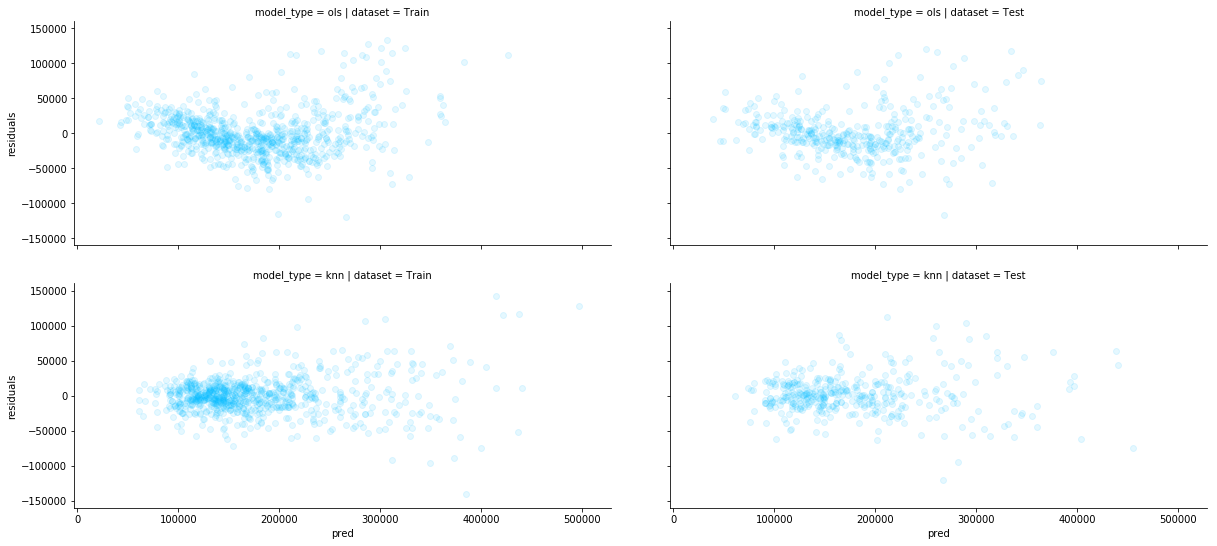

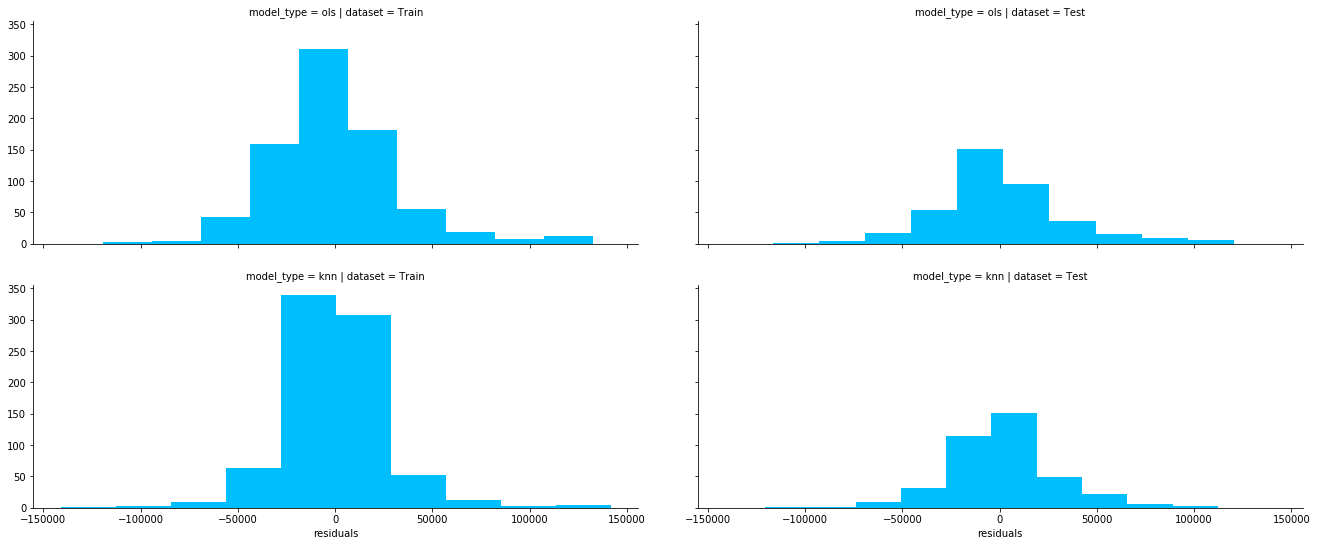

In [89]:
comb = pd.concat([results, knn_pred], axis=0, sort=True)
comb.loc[:, 'actual'] = comb.actual.astype(float)
comb.loc[:, 'pred'] = comb.pred.astype(float)
comb['residuals'] = comb.actual - comb.pred

expNo = 15
select = comb.loc[(comb.exp_no==expNo) & (comb.pred < 600000) & (comb.residuals.abs() < 150000)]
g = sns.FacetGrid(select, col='dataset', row='model_type')
g.map(plt.scatter, 'pred', 'residuals', alpha=0.1, color='deepskyblue')
f = plt.gcf()
f.set_size_inches(20, 8)
plt.show()

g = sns.FacetGrid(select, col='dataset', row='model_type')
g.map(plt.hist, 'residuals', color='deepskyblue')
f = plt.gcf()
f.set_size_inches(20, 8)
plt.show()

# Model 5: PLSR with scaled continuous variables

## OLS with 2 PLSR components

In [129]:
from sklearn.cross_decomposition import PLSRegression as plsr

plsr_pred = pd.DataFrame(columns=results.columns)
plsr_results = pd.DataFrame(columns=runs.columns)

X = feat[[x for x in feat.columns if x != 'saleprice']]
y = feat.saleprice

for i in range(100):
    X_train, X_test, y_train, y_test = tts(X, y, test_size=0.33)
    
    scale = StandardScaler()
    X_sc_train = scale.fit_transform(X_train)
    X_sc_test = scale.transform(X_test)
    
    preg = plsr(2).fit(X_sc_train, y_train)
    X_tr_plsr = preg.transform(X_sc_train)
    X_ts_plsr = preg.transform(X_sc_test)
    
    ols = lr().fit(X_tr_plsr, y_train)
    y_tr = ols.predict(X_tr_plsr)
    y_ts = ols.predict(X_ts_plsr)
    
    train = pd.DataFrame({'actual': y_train,
                         'pred': y_tr.ravel(),
                         'dataset': 'Train'})
    
    test = pd.DataFrame({'actual': y_test,
                        'pred': y_ts.ravel(),
                        'dataset': 'Test'})
    
    comb = pd.concat([train, test], axis=0, sort=True)
    comb['exp_no'] = i
    comb['model_type'] = 'ols'
    
    plsr_pred = pd.concat([plsr_pred, comb], axis=0, sort=True)
    
    rrow = {'exp_no': i,
           'r2_train': r2(y_train, y_tr),
           'r2_test': r2(y_test, y_ts),
           'mse_train': mse(y_train, y_tr),
           'mse_test': mse(y_test, y_ts),
           'model_type': 'ols'}
    
    plsr_results = plsr_results.append(rrow, ignore_index=True)
    
print('Number of trials: {0}\n'.format(len(plsr_results.loc[plsr_results.model_type=='ols'].index)))
print('Mean model R2: {0}'.format(round(plsr_results.loc[plsr_results.model_type=='ols', 'r2_train'].mean(), ndigits=nd)))
print('STD model R2: {0}'.format(round(plsr_results.loc[plsr_results.model_type=='ols', 'r2_train'].std(), ndigits=nd)))
print('Mean model MSE: {0}\n'.format(round(plsr_results.loc[plsr_results.model_type=='ols', 'mse_train'].mean(), ndigits=nd)))
print('Mean test R2: {0}'.format(round(plsr_results.loc[plsr_results.model_type=='ols', 'r2_test'].mean(), ndigits=nd)))
print('STD test R2: {0}'.format(round(plsr_results.loc[plsr_results.model_type=='ols', 'r2_test'].std(), ndigits=nd)))
print('Mean test MSE: {0}'.format(round(plsr_results.loc[plsr_results.model_type=='ols', 'mse_test'].mean(), ndigits=nd)))

Number of trials: 100

Mean model R2: 0.7497
STD model R2: 0.0424
Mean model MSE: 1739509397.6321

Mean test R2: 0.7028
STD test R2: 0.1068
Mean test MSE: 2016538194.1083


## OLS with 4 PLSR components

In [131]:
plsr_pred = pd.DataFrame(columns=results.columns)
plsr_results = pd.DataFrame(columns=runs.columns)

X = feat[[x for x in feat.columns if x != 'saleprice']]
y = feat.saleprice

for i in range(100):
    X_train, X_test, y_train, y_test = tts(X, y, test_size=0.33)
    
    scale = StandardScaler()
    X_sc_train = scale.fit_transform(X_train)
    X_sc_test = scale.transform(X_test)
    
    preg = plsr(4).fit(X_sc_train, y_train)
    X_tr_plsr = preg.transform(X_sc_train)
    X_ts_plsr = preg.transform(X_sc_test)
    
    ols = lr().fit(X_tr_plsr, y_train)
    y_tr = ols.predict(X_tr_plsr)
    y_ts = ols.predict(X_ts_plsr)
    
    train = pd.DataFrame({'actual': y_train,
                         'pred': y_tr.ravel(),
                         'dataset': 'Train'})
    
    test = pd.DataFrame({'actual': y_test,
                        'pred': y_ts.ravel(),
                        'dataset': 'Test'})
    
    comb = pd.concat([train, test], axis=0, sort=True)
    comb['exp_no'] = i
    comb['model_type'] = 'ols'
    
    plsr_pred = pd.concat([plsr_pred, comb], axis=0, sort=True)
    
    rrow = {'exp_no': i,
           'r2_train': r2(y_train, y_tr),
           'r2_test': r2(y_test, y_ts),
           'mse_train': mse(y_train, y_tr),
           'mse_test': mse(y_test, y_ts),
           'model_type': 'ols'}
    
    plsr_results = plsr_results.append(rrow, ignore_index=True)
    
print('Number of trials: {0}\n'.format(len(plsr_results.loc[plsr_results.model_type=='ols'].index)))
print('Mean model R2: {0}'.format(round(plsr_results.loc[plsr_results.model_type=='ols', 'r2_train'].mean(), ndigits=nd)))
print('STD model R2: {0}'.format(round(plsr_results.loc[plsr_results.model_type=='ols', 'r2_train'].std(), ndigits=nd)))
print('Mean model MSE: {0}\n'.format(round(plsr_results.loc[plsr_results.model_type=='ols', 'mse_train'].mean(), ndigits=nd)))
print('Mean test R2: {0}'.format(round(plsr_results.loc[plsr_results.model_type=='ols', 'r2_test'].mean(), ndigits=nd)))
print('STD test R2: {0}'.format(round(plsr_results.loc[plsr_results.model_type=='ols', 'r2_test'].std(), ndigits=nd)))
print('Mean test MSE: {0}'.format(round(plsr_results.loc[plsr_results.model_type=='ols', 'mse_test'].mean(), ndigits=nd)))

Number of trials: 100

Mean model R2: 0.7452
STD model R2: 0.0372
Mean model MSE: 1755689872.7327

Mean test R2: 0.7161
STD test R2: 0.0978
Mean test MSE: 1955203465.4575


Unlike with PCA, increasing the number of PLSR components from two to four didn't make a huge difference. There's a slight decrease in the difference between the model and test R2 values, and a slight decrease in the standard deviation in both the model and test R2 standard deviation. However, this is by far the best performance we've seen so far, with a test R2 of  over 0.7.

## KNN with 2 PLSR components

In [149]:
plsr_pred = plsr_pred.loc[plsr_pred.model_type=='ols']
plsr_results = plsr_results.loc[plsr_results.model_type=='ols']
knn_results = pd.DataFrame(columns=plsr_results.columns)
knn_pred = pd.DataFrame(columns=plsr_pred.columns)

for i in range(100):
    X_train, X_test, y_train, y_test = tts(X, y, test_size=0.33)
    
    scale = StandardScaler()
    X_sc_train = scale.fit_transform(X_train)
    X_sc_test = scale.transform(X_test)
    
    preg = plsr(2).fit(X_sc_train, y_train)
    X_tr_plsr = preg.transform(X_sc_train)
    X_ts_plsr = preg.transform(X_sc_test)
    
    kreg = knnr(n_neighbors=5)  
    kreg.fit(X_tr_plsr, y_train)
    
    y_tr = kreg.predict(X_tr_plsr)
    y_ts = kreg.predict(X_ts_plsr)
    
    train = pd.DataFrame({'actual': y_train,
                         'pred': y_tr.ravel(),
                         'dataset': 'Train'})
    
    test = pd.DataFrame({'actual': y_test,
                        'pred': y_ts.ravel(),
                        'dataset': 'Test'})
    
    comb = pd.concat([train, test], axis=0, sort=True)
    comb['exp_no'] = i
    comb['model_type'] = 'knn'
    
    plsr_pred = pd.concat([plsr_pred, comb], axis=0, sort=True)
    
    rrow = {'exp_no': i,
           'r2_train': r2(y_train, y_tr),
           'r2_test': r2(y_test, y_ts),
           'mse_train': mse(y_train, y_tr),
           'mse_test': mse(y_test, y_ts),
           'model_type': 'knn'}
    
    plsr_results = plsr_results.append(rrow, ignore_index=True)
    
print('Number of trials: {0}\n'.format(len(plsr_results.loc[plsr_results.model_type=='knn'].index)))
print('Mean model R2: {0}'.format(round(plsr_results.loc[plsr_results.model_type=='knn', 'r2_train'].mean(), ndigits=nd)))
print('STD model R2: {0}'.format(round(plsr_results.loc[plsr_results.model_type=='knn', 'r2_train'].std(), ndigits=nd)))
print('Mean model MSE: {0}\n'.format(round(plsr_results.loc[plsr_results.model_type=='knn', 'mse_train'].mean(), ndigits=nd)))
print('Mean test R2: {0}'.format(round(plsr_results.loc[plsr_results.model_type=='knn', 'r2_test'].mean(), ndigits=nd)))
print('STD test R2: {0}'.format(round(plsr_results.loc[plsr_results.model_type=='knn', 'r2_test'].std(), ndigits=nd)))
print('Mean test MSE: {0}'.format(round(plsr_results.loc[plsr_results.model_type=='knn', 'mse_test'].mean(), ndigits=nd)))

Number of trials: 100

Mean model R2: 0.8587
STD model R2: 0.0162
Mean model MSE: 979641969.0886

Mean test R2: 0.7825
STD test R2: 0.0428
Mean test MSE: 1478082362.0624


In [147]:
plsr_pred = plsr_pred.loc[plsr_pred.model_type=='ols']
plsr_results = plsr_results.loc[plsr_results.model_type=='ols']
knn_results = pd.DataFrame(columns=plsr_results.columns)
knn_pred = pd.DataFrame(columns=plsr_pred.columns)

for i in range(100):
    X_train, X_test, y_train, y_test = tts(X, y, test_size=0.33)
    
    scale = StandardScaler()
    X_sc_train = scale.fit_transform(X_train)
    X_sc_test = scale.transform(X_test)
    
    preg = plsr(4).fit(X_sc_train, y_train)
    X_tr_plsr = preg.transform(X_sc_train)
    X_ts_plsr = preg.transform(X_sc_test)
    
    kreg = knnr(n_neighbors=5)  
    kreg.fit(X_tr_plsr, y_train)
    
    y_tr = kreg.predict(X_tr_plsr)
    y_ts = kreg.predict(X_ts_plsr)
    
    train = pd.DataFrame({'actual': y_train,
                         'pred': y_tr.ravel(),
                         'dataset': 'Train'})
    
    test = pd.DataFrame({'actual': y_test,
                        'pred': y_ts.ravel(),
                        'dataset': 'Test'})
    
    comb = pd.concat([train, test], axis=0, sort=True)
    comb['exp_no'] = i
    comb['model_type'] = 'knn'
    
    plsr_pred = pd.concat([plsr_pred, comb], axis=0, sort=True)
    
    rrow = {'exp_no': i,
           'r2_train': r2(y_train, y_tr),
           'r2_test': r2(y_test, y_ts),
           'mse_train': mse(y_train, y_tr),
           'mse_test': mse(y_test, y_ts),
           'model_type': 'knn'}
    
    plsr_results = plsr_results.append(rrow, ignore_index=True)
    
print('Number of trials: {0}\n'.format(len(plsr_results.loc[plsr_results.model_type=='knn'].index)))
print('Mean model R2: {0}'.format(round(plsr_results.loc[plsr_results.model_type=='knn', 'r2_train'].mean(), ndigits=nd)))
print('STD model R2: {0}'.format(round(plsr_results.loc[plsr_results.model_type=='knn', 'r2_train'].std(), ndigits=nd)))
print('Mean model MSE: {0}\n'.format(round(plsr_results.loc[plsr_results.model_type=='knn', 'mse_train'].mean(), ndigits=nd)))
print('Mean test R2: {0}'.format(round(plsr_results.loc[plsr_results.model_type=='knn', 'r2_test'].mean(), ndigits=nd)))
print('STD test R2: {0}'.format(round(plsr_results.loc[plsr_results.model_type=='knn', 'r2_test'].std(), ndigits=nd)))
print('Mean test MSE: {0}'.format(round(plsr_results.loc[plsr_results.model_type=='knn', 'mse_test'].mean(), ndigits=nd)))

Number of trials: 100

Mean model R2: 0.862
STD model R2: 0.0143
Mean model MSE: 953853947.9702

Mean test R2: 0.7862
STD test R2: 0.0469
Mean test MSE: 1467987180.5751


PLSR with KNN gave us our best results yet. Two components performs very slightly better than four components as determined by the difference between average model R2 and average test R2. Still, it's a very, very small change.

## Plotting residuals

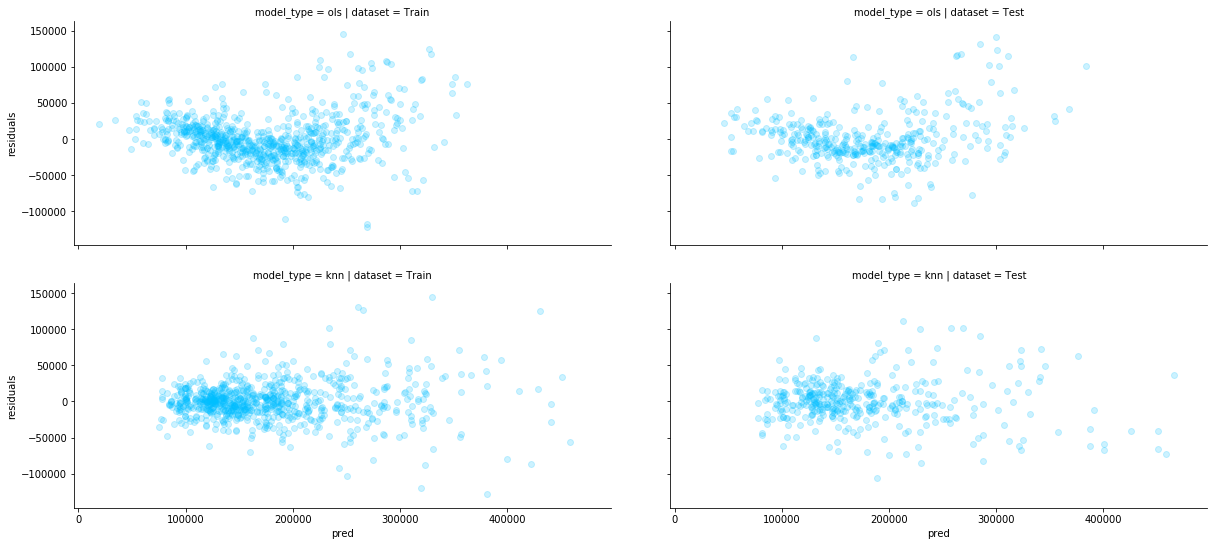

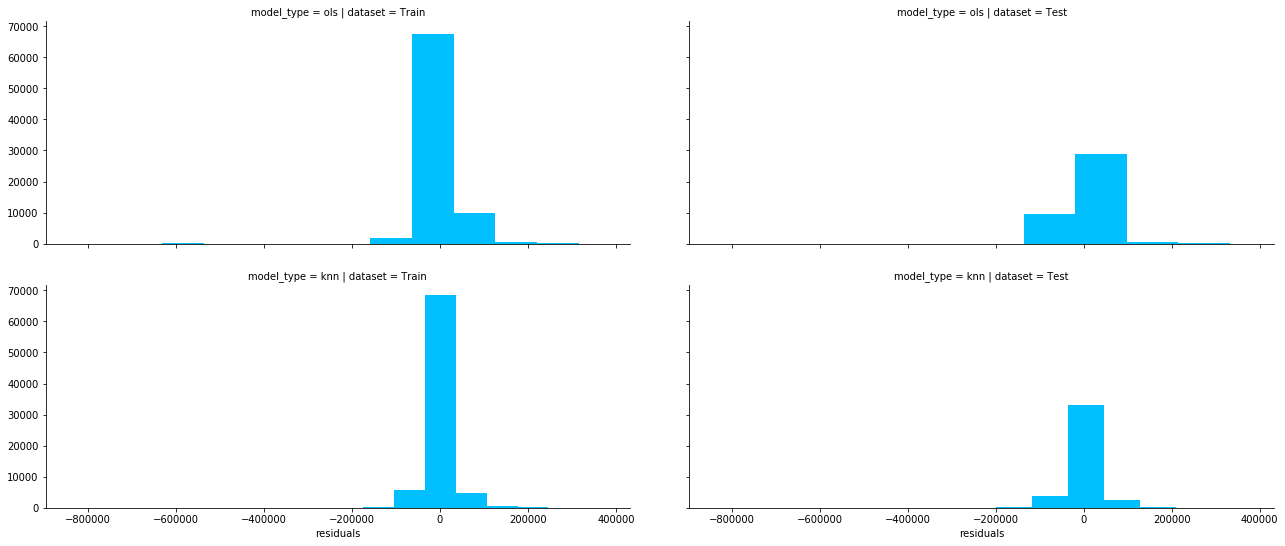

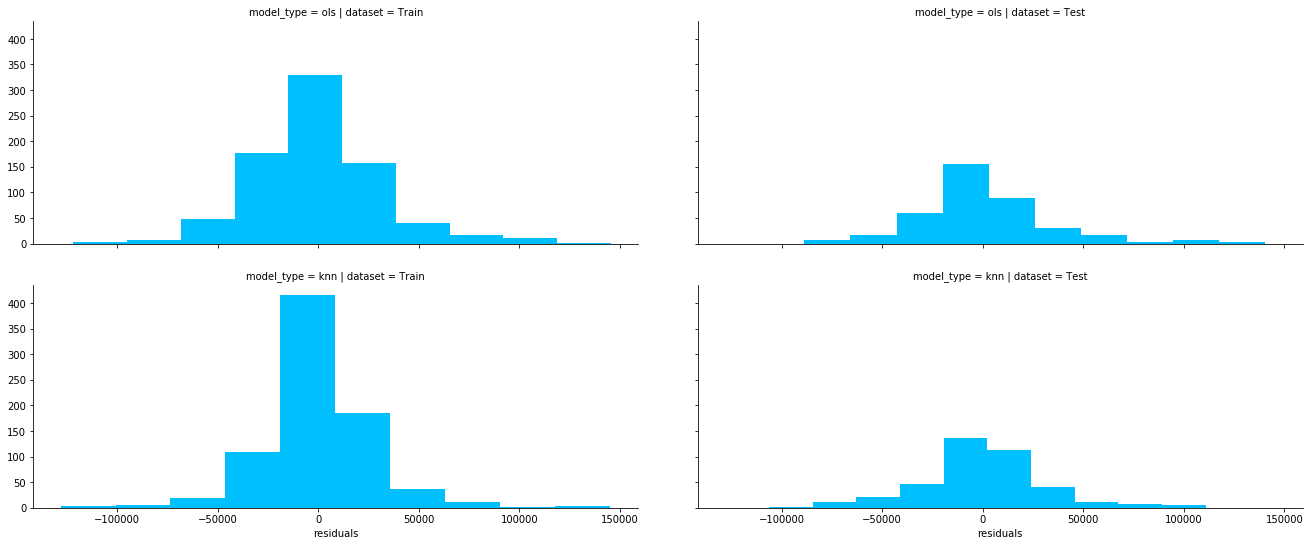

In [156]:
plsr_pred.dtypes
plsr_pred.loc[:, 'actual'] = plsr_pred.actual.astype(float)
plsr_pred.loc[:, 'pred'] = plsr_pred.pred.astype(float)
plsr_pred['residuals'] = plsr_pred.actual - plsr_pred.pred

show = plsr_pred[(plsr_pred.exp_no==15) &
                (plsr_pred.pred < 500000) &
                (plsr_pred.residuals.abs() < 150000)]

g = sns.FacetGrid(show, col='dataset', row='model_type')
g.map(plt.scatter, 'pred', 'residuals', color='deepskyblue', alpha=0.2)
f = plt.gcf()
f.set_size_inches(20, 8)
plt.show()

g = sns.FacetGrid(plsr_pred, col='dataset', row='model_type')
g.map(plt.hist, 'residuals', color='deepskyblue')
f = plt.gcf()
f.set_size_inches(20, 8)
plt.show()

g = sns.FacetGrid(show, col='dataset', row='model_type')
g.map(plt.hist, 'residuals', color='deepskyblue')
f = plt.gcf()
f.set_size_inches(20, 8)
plt.show()

The residuals look pretty good, albeit left-tailed. There's still the curve in the OLS residual plots indicating some kind of polynonial relationship with one or more indicator variables.

# Conclusions
In no particular order:
- Linear transformations will not correct non-linear relationships between indicator and target;
- Scaling appears to help with performance and overfitting in both KNN and OLS;
- PLSR seems more helpful in dimension reduction than PCA, which makes sense given that it looks specifically for components that covary wtih the target variable.
- Increasing PLSR components did not have as big an impact as increasing PCA components, which would make sense since PLSR looks for variables that covary with the target while PCA looks to increase the most variance in the indicator variables. The most variation isn't necessarily capturing the variation that is most correlated to the target, however.

# Data discovery

In [ ]:
f, ax = plt.subplots(figsize=(20, 6))
ax.hist(md.levels, bins=50)
plt.title('Distribution of Variable Levels for All Variables')
plt.xlabel('Levels')
plt.ylabel('Records')
plt.show()

f, ax = plt.subplots(figsize=(20, 6))
ax.hist(md.loc[md.levels<60, 'levels'], bins=50)
plt.title('Distribution of Variable Levels for Likely Categorical Variables (levels < 60)')
plt.xlabel('Levels')
plt.ylabel('Records')
plt.show()

## Correlation analysis among continuous variables

In [ ]:
bln = pd.DataFrame(d.apply(lambda x: sum(x.isna())/len(d.index)), columns=["null_records"])
bln['unique_num'] = d.apply(lambda x: len(x.drop_duplicates().index))
bln['d_type'] = d.dtypes
bln = bln.drop('id')
# cnt = bln.loc[bln.d_type.isin(np.int64, np.float64)]

cdf = bln.loc[((bln.d_type == np.float64) | (bln.d_type == np.int64)) & (bln.unique_num>60)]

In [ ]:
sc = d[cdf.index].melt(id_vars='saleprice')

g = sns.FacetGrid(sc, row='variable', sharex=False, aspect=3, height=3)
g.map(sns.regplot, 'value', 'saleprice', scatter_kws={'alpha': 0.3})
plt.show()

keep_cnt = ['lotfrontage', 'lotarea', 'yearremodadd', 'yearbuilt', 
            'masvnrarea', 'bsmtfinsf1', 'totalbsmtsf', '1stflrsf',
           '2ndflrsf', 'grlivarea', 'garagearea', 'wooddecksf']

int_var = ['2ndfl', 'grg', 'bsmt']

In [ ]:
cor = d[cdf.index].corr()

sns.heatmap(cor.abs(), square=True, cmap='bwr')
plt.show()

## Lot frontage null values

In [ ]:
# Distribution of Lot Frontage values
lf = feat.lotfrontage.dropna()
plt.hist(lf, bins=30)
plt.axvline(lf.median(), color='r')
plt.xlim(0, lf.max())
plt.title('Lot Frontage Value Distribution')
plt.xlabel('Values')
plt.ylabel('Records')
plt.show()


# Relationship between lot frontage value and lot area
lfla = d.loc[d.lotarea < 60000, ['lotfrontage', 'lotarea']]
f, ax = plt.subplots(figsize=(20, 6))
sns.regplot('lotarea', 'lotfrontage', data=lfla, scatter_kws={'alpha': 0.2}, ax=ax)
plt.xlabel('Lot Area')
plt.ylabel('Lot Frontage')
plt.title('Relationship Between Lot Area and Lot Frontage')
plt.show()

# Distribution of lot area values when lot frontage is null
la = d.loc[d.lotfrontage.isna(), 'lotarea']
f, ax = plt.subplots(figsize=(20, 6))
ax.hist(la, bins=50)
ax.axvline(la.median(), color='r')
plt.xlabel('Lot Area')
plt.ylabel('Records')
plt.title('Lot Area Distribution for Null Lot Frontage')
plt.show()

print('Median lot area for null values of lot frontage: {0}'.format(la.median()))
print('Mean lot area for null values of lot frontage: {0}'.format(round(la.mean(), ndigits=1)))

# Testing

### Testing reconcile function

In [ ]:
# Defining columns for test dataframes
rec_test_cols = ['test1', 'test2']
false_add = ['one', 'two', 'three']
false_drop = ['four', 'five', 'six']

# Test dataframes
false_test = pd.DataFrame(np.zeros(shape=(20, len(rec_test_cols))), columns=rec_test_cols)
false_train = pd.DataFrame(np.zeros(shape=(300, len(rec_test_cols))), columns=rec_test_cols)
false_train2 = pd.DataFrame(np.zeros(shape=(300, len(rec_test_cols+false_add))), columns=rec_test_cols+false_add)
false_test2 = pd.DataFrame(np.zeros(shape=(20, len(rec_test_cols+false_drop))), columns=rec_test_cols+false_drop)

# # Test when columns are equal
# reconcile(false_test, false_train)

# # Test when training contains additional columns
# reconcile(false_test, false_train2)

# # Test when test contains additional columns
# reconcile(false_test2, false_train)

# # Test when both contain additional columns
reconcile(false_test2, false_train2)

# Discarded code

## DC1: Trying to one hot encode when I couldn't get OneHotEncoder to work

#### Workaround for not figuring out how to drop a feature variable in sklearn OneHotEncoding

In [ ]:
# Reconcile function drops columns from the testing dataset that aren't in training
# and adds dummy columns in the test dataset that are in train but not test
def reconcile(test, train):
    df = test.copy()
    add = train.columns.difference(test.columns)
    drp = test.columns.difference(train.columns)
    if len(drp)>0:
        df = dr.drop(drp.values, axis=1)
    if len(add)>0:
        dummy = pd.DataFrame(np.zeros(shape=(test.shape[0], len(add))), columns=add.values)
        df = pd.concat([df, dummy], axis=1)
    return(df)

def test_recon(test, train):
    add = train.columns.difference(test.columns)
    drp = test.columns.difference(train.columns)
    if len(over_test)>0:
        print('{0} columns in testing dataset that are not in training dataset:'.format(len(over_test)))
        print(over_test)
        return(False)
    elif len(over_train)>0:
        print('\n{0} columns in training dataset that need to be added to testing dataset:'.format(len(over_train)))
        print(over_train)
        return(False)
    else:
        print('Training and testing columns match')
        return(True)

X_test_cln = reconcile(X_test2, X_train_cln)
test_recon(X_test_cln, X_train_cln)

#### Generating dummy features using pandas.get_dummies

In [ ]:
X_train_cln = pd.get_dummies(X_train1,
                          columns=list(filter(lambda x: x not in ('condition1', 'condition2'), cat)),
                          drop_first=True)

X_test2 = pd.get_dummies(X_test1,
                         columns=list(filter(lambda x: x not in ('condition1', 'condition2'), cat)),
                         drop_first=True)